# プロダクト開発. SRCNNとU-Netを使った低解像度の画像を高解像度に変換する



以下の流れで行います。<br>
1.データセットの準備<br>
2.DAEモデルの構築<br>
3.FCNモデルの構築<br>
4.トレーニング<br>
5.テスト<br>
6.評価・考察<br>



## 1.データセットの準備

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision
import torchvision.transforms as transforms
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# データセットのダウンロードと前処理
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # 解像度を低くする
    transforms.Resize((32, 32)),  # 元のサイズに戻す
    transforms.ToTensor()
])

'''CIFAR-10データセットの訓練用部分を'./data'ディレクトリにダウンロードし、指定したtransform（前処理手順）を適用して、それをtrainsetという変数に格納,
train=Trueは訓練用データセットを指定,download=Trueはデータセットがまだローカルに存在しない場合にダウンロードするよう指示'''
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainsetからデータをバッチで読み込むためのDataLoaderを作成。batch_size=4は、各バッチに4枚の画像を含むようにすることを指示、shuffle=Trueは、エポックごとにデータをランダムにシャッフルすることを意味
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

#テスト用
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## 2.DAEモデル（ノイズ除去オートエンコーダ）の構築

In [14]:
class DAE(nn.Module):
    def __init__(self):
        #nn.Moduleのコンストラクタの呼び出し
        super(DAE, self).__init__()
        #畳み込み層:入力チャンネル数,出力チャンネル数,カーネルサイズ〇x〇,パディング
        # エンコーダ
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        #最大プーリングを行う層,特徴マップのサイズは半分になる
        self.pool = nn.MaxPool2d(2, 2)

        # デコーダ
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2)

    def forward(self, x):
        # エンコーディング
        x = F.relu(self.enc_conv1(x))
        x = self.pool(x)
        x = F.relu(self.enc_conv2(x))
        x = self.pool(x)
        x = F.relu(self.enc_conv3(x))
        x = self.pool(x)

        # デコーディング
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = torch.sigmoid(self.dec_conv3(x))
        return x
# モデルのインスタンス化
dae = DAE()

## 3.FCNモデル（完全畳み込みネットワーク）の構築
 セグメンテーションや高解像度化

In [15]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        # エンコーダ,畳み込み層
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        #プーリング層,2x2のウィンドウで最大プーリングを行い、特徴マップのサイズを縮小
        self.pool = nn.MaxPool2d(2, 2)

        # デコーダ,逆畳み込み層（アップサンプリング用）
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2)

    def forward(self, x):
        # エンコーディング
        x = F.relu(self.enc_conv1(x))
        x = self.pool(x)
        x = F.relu(self.enc_conv2(x))
        x = self.pool(x)
        x = F.relu(self.enc_conv3(x))
        x = self.pool(x)

        # デコーディング
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = torch.sigmoid(self.dec_conv3(x))
        return x

fcn = FCN()

## 4.トレーニング

[1, 2000] loss: 0.009
[1, 4000] loss: 0.003
[1, 6000] loss: 0.003
[1, 8000] loss: 0.002
[1, 10000] loss: 0.002
[1, 12000] loss: 0.002
[2, 2000] loss: 0.001
[2, 4000] loss: 0.001
[2, 6000] loss: 0.001
[2, 8000] loss: 0.001
[2, 10000] loss: 0.001
[2, 12000] loss: 0.001
[3, 2000] loss: 0.001
[3, 4000] loss: 0.001
[3, 6000] loss: 0.001
[3, 8000] loss: 0.001
[3, 10000] loss: 0.001
[3, 12000] loss: 0.001
[4, 2000] loss: 0.001
[4, 4000] loss: 0.001
[4, 6000] loss: 0.001
[4, 8000] loss: 0.001
[4, 10000] loss: 0.001
[4, 12000] loss: 0.001
[5, 2000] loss: 0.001
[5, 4000] loss: 0.001
[5, 6000] loss: 0.001
[5, 8000] loss: 0.001
[5, 10000] loss: 0.001
[5, 12000] loss: 0.001
[6, 2000] loss: 0.001
[6, 4000] loss: 0.001
[6, 6000] loss: 0.001
[6, 8000] loss: 0.001
[6, 10000] loss: 0.001
[6, 12000] loss: 0.001
[7, 2000] loss: 0.001
[7, 4000] loss: 0.001
[7, 6000] loss: 0.001
[7, 8000] loss: 0.001
[7, 10000] loss: 0.001
[7, 12000] loss: 0.001
[8, 2000] loss: 0.001
[8, 4000] loss: 0.001
[8, 6000] loss: 0.

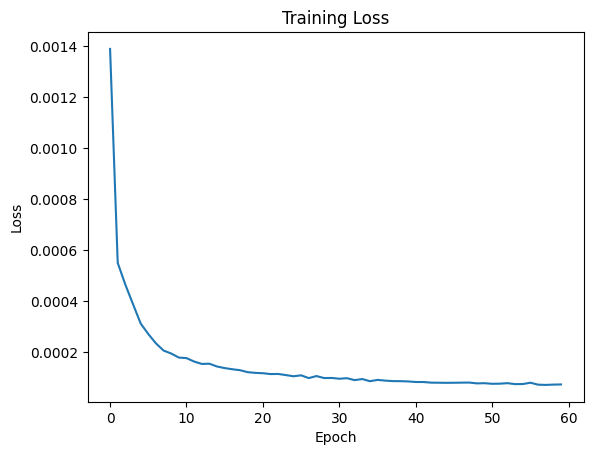

In [16]:
# DAEとFCNモデルのインスタンス化
dae = DAE()
fcn = FCN()

# 損失関数と最適化アルゴリズム
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(dae.parameters()) + list(fcn.parameters()), lr=0.001)

# トレーニングループ
epoch_losses = []  # 各エポックの損失を記録するリスト
num_epochs = 10
for epoch in range(num_epochs):
    #現在のエポックにおける累積損失を追跡するための変数、エポックの最初に0に初期化される
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        # ゼロ勾配を設定
        optimizer.zero_grad()

        # DAEとFCNを通じた順伝播
        features = dae(inputs)
        outputs = fcn(features)

        # 損失の計算とバックプロパゲーション
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        #running_lossは、現在のエポックにおける累積損失の合計,loss.item()は、現在のバッチにおける損失の値を取得して、running_lossに加算
        running_loss += loss.item()
        #現在のバッチインデックスiが2000の倍数の直前（つまり1999, 3999, 5999, ...）であるかどうかをチェック
        if i % 2000 == 1999:
             # グラフに表示させるためにエポックごとの平均損失を計算してリストに追加
            epoch_loss = running_loss / len(trainloader)
            epoch_losses.append(epoch_loss)
            #現在のエポック数とバッチインデックスを表示し、その後に過去2000バッチの平均損失を表示
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            #running_lossを0にリセットします。これにより、次の2000バッチのための新たな累積損失の計算が始まる
            running_loss = 0.0

print('Finished Training')

#グラフの表示
plt.plot(epoch_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 5.テスト

In [38]:
# PSNRピーク信号対雑音比）とSSIM（構造類似度指標）の計算
#model（評価したいニューラルネットワークモデル）とtestloader（テストデータをロードするためのデータローダー）
def calculate_psnr_ssim(model, testloader):
    model.eval()
    psnr_values = []
    ssim_values = []

    #評価中にモデルのパラメータを更新しないように勾配計算を無効化
    with torch.no_grad():
        for inputs, _ in testloader:
            outputs = model(inputs)
            
            inputs = inputs / 2.0 + 0.5  # 正規化
            outputs = outputs / 2.0 + 0.5  # 正規化

            #入力と出力のペアを繰り返し処理
            for inp, out in zip(inputs, outputs):
                #入力と出力のテンソルから余分な次元を削除し、PyTorchのテンソルからNumPy配列に変換detach()は、テンソルが計算グラフに含まれないようにし、.cpu()はデータをCPUメモリに移動
                inp = inp.squeeze().detach().cpu().numpy()
                out = out.squeeze().detach().cpu().numpy()
                
                # 画像サイズに基づいてwin_sizeを設定
                win_size = min(inp.shape[1], inp.shape[2], 3)  # 画像の幅と高さ、および

                #PSNR値を計算
                p = psnr(inp, out, data_range=1)
                #SSIM値を計算
                s = ssim(inp, out, data_range=1, multichannel=True, win_size=win_size)

                psnr_values.append(p)
                ssim_values.append(s)

    return psnr_values, ssim_values

# モデルの性能評価
average_psnr, average_ssim = calculate_psnr_ssim(fcn, testloader)
print(f'Average PSNR: {average_psnr}, Average SSIM: {average_ssim}')

Average PSNR: [20.45693866229463, 15.906825239471111, 17.796133463480423, 18.603875786574896, 20.967458379708297, 18.511592343761063, 15.848228406554409, 17.753525594352183, 19.742108304451392, 18.209981248555593, 26.42458422253373, 18.377488760470342, 17.749864185567045, 15.087076270591414, 19.813095610381673, 20.698666115212486, 16.768855346709646, 19.94788223698809, 14.86802063273352, 18.45054378178706, 18.53639129232285, 13.080754950607364, 18.979401346187274, 18.12046354401733, 20.855930448544786, 20.015596607650778, 17.834233752372196, 18.484490305157223, 18.392759759868312, 16.886236406923178, 15.733004936642521, 21.815378350629917, 23.979884441439992, 17.101561970487754, 17.632101984736053, 16.89490246681389, 21.412608775688163, 16.87034270544358, 18.927605474413532, 20.18315741078045, 19.985757729717122, 14.86627102226311, 16.9785591093096, 17.67051718168562, 18.076723728441003, 18.87304253312459, 18.03702248140841, 21.083405583794086, 20.671059633184477, 19.073560905335935, 1

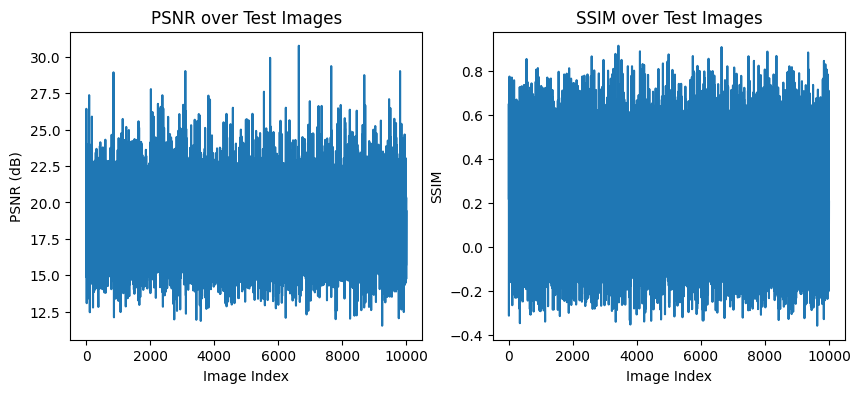

Original Image


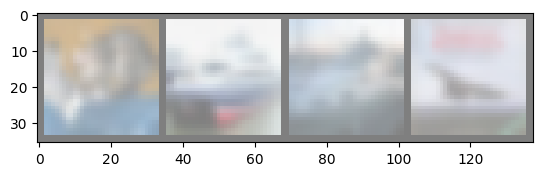

Low Resolution Image


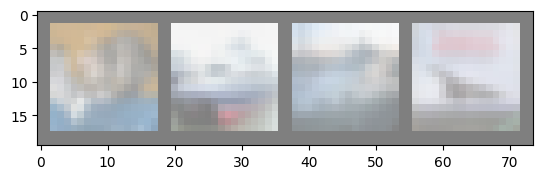

Reconstructed High Resolution Image


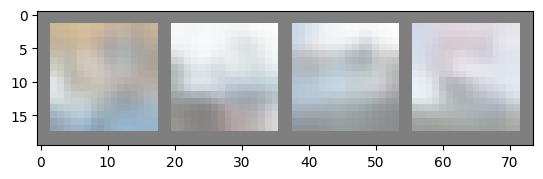

In [39]:
# 訓練されたモデルとテストデータローダーを使ってPSNRとSSIMを計算する
'''PSNRは、画像が持つ最大可能なパワーと誤差のパワーの比をデシベル（dB）単位で表したもの。PSNRの値が高いほど、画像品質が良い
　SSIMは画像の構造的な類似性を測る値で、0から1の間の値を取ります。1に近づくほど、参照画像と比較して高い類似性があることを意味します。'''
psnr_list, ssim_list = calculate_psnr_ssim(fcn, testloader)

# PSNRとSSIMの値をプロットする
plt.figure(figsize=(10, 4))

# PSNR値のためのサブプロット
plt.subplot(1, 2, 1)
plt.plot(psnr_list)
plt.title('PSNR over Test Images')
plt.xlabel('Image Index')
plt.ylabel('PSNR (dB)')

# Subplot for SSIM values
plt.subplot(1, 2, 2)
plt.plot(ssim_list)
plt.title('SSIM over Test Images')
plt.xlabel('Image Index')
plt.ylabel('SSIM')

# Display the plot
plt.show()


#テストデータセットから画像を表示
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# ランダムに画像を選択して表示
dataiter = iter(testloader)
images, labels = next(dataiter)

# 元の高解像度画像
print("Original Image")
imshow(torchvision.utils.make_grid(images))

# 低解像度画像
low_res_images = F.interpolate(images, scale_factor=0.5)
print("Low Resolution Image")
imshow(torchvision.utils.make_grid(low_res_images))

# モデルによって再構築された高解像度画像
with torch.no_grad():
    dae_output = dae(low_res_images)
    fcn_output = fcn(dae_output)
print("Reconstructed High Resolution Image")
imshow(torchvision.utils.make_grid(fcn_output))

## 6.評価・考察

<font color="red"><strong>考察</storng></font>

<font color="blue"><storng>視覚的評価:</strong></font> 
かなりのぼやけがあり、元の画像と比較すると、解像度やクリアさが不足している<br>
⇒モデルの調整や異なるアプローチを検討

<font color="blue"><storng>定量的評価:</strong></font>  
グラフからは画像の品質が比較的良好であると示されている。SSIMに関してはまだ改善の余地がありそう

<font color="red"><storng>改善: </strong></font>  
<font color="blue"><storng>アーキテクチャの改良</strong></font> 
⇒Attention Mechanisms: 画像の重要な特徴に焦点を当てることで、より関連性の高い情報をモデルが捉えられるようにする。<br>
メリット:
勾配の消失/爆発問題の軽減: 残差ブロックを通じて勾配が直接伝播するため、深いネットワークでも効果的訓練に可能。
効率的なトレーニング: 残差接続により、ネットワークはアイデンティティ関数をするのが容易になり、学習が速くなる傾向があります。


Attention Mechanisms（アテンションメカニズム）
クエリ（Query）: 現在の焦点となる情報（例：現在処理している単語）。
キー（Key）: 比較の対象となる情報（例：文内の他の単語）。
バリュー（Value）: キーに関連付けられた情報で、アテンションの重みによって重要度がスケールされます。
アテンションは、クエリに基づいてキーとの関連性スコアを計算し、そのスコアを使用してバリューの重みづけ合計を行います。これにより、特定の情報に「注意を払う」ことができます。

今回の場合は、エンコーダとデコーダの間にアテンションメカニズムを追加する。畳み込み層を通じてアテンションマップを生成して入力特徴マップをスケールします。